# Overhead (Single Parameter) 


This is the Notebook used to analyze whether any additional overhead is added by parameter control.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


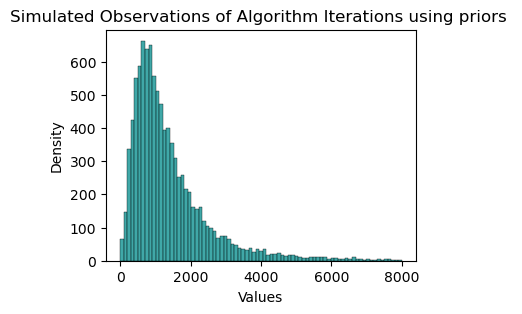

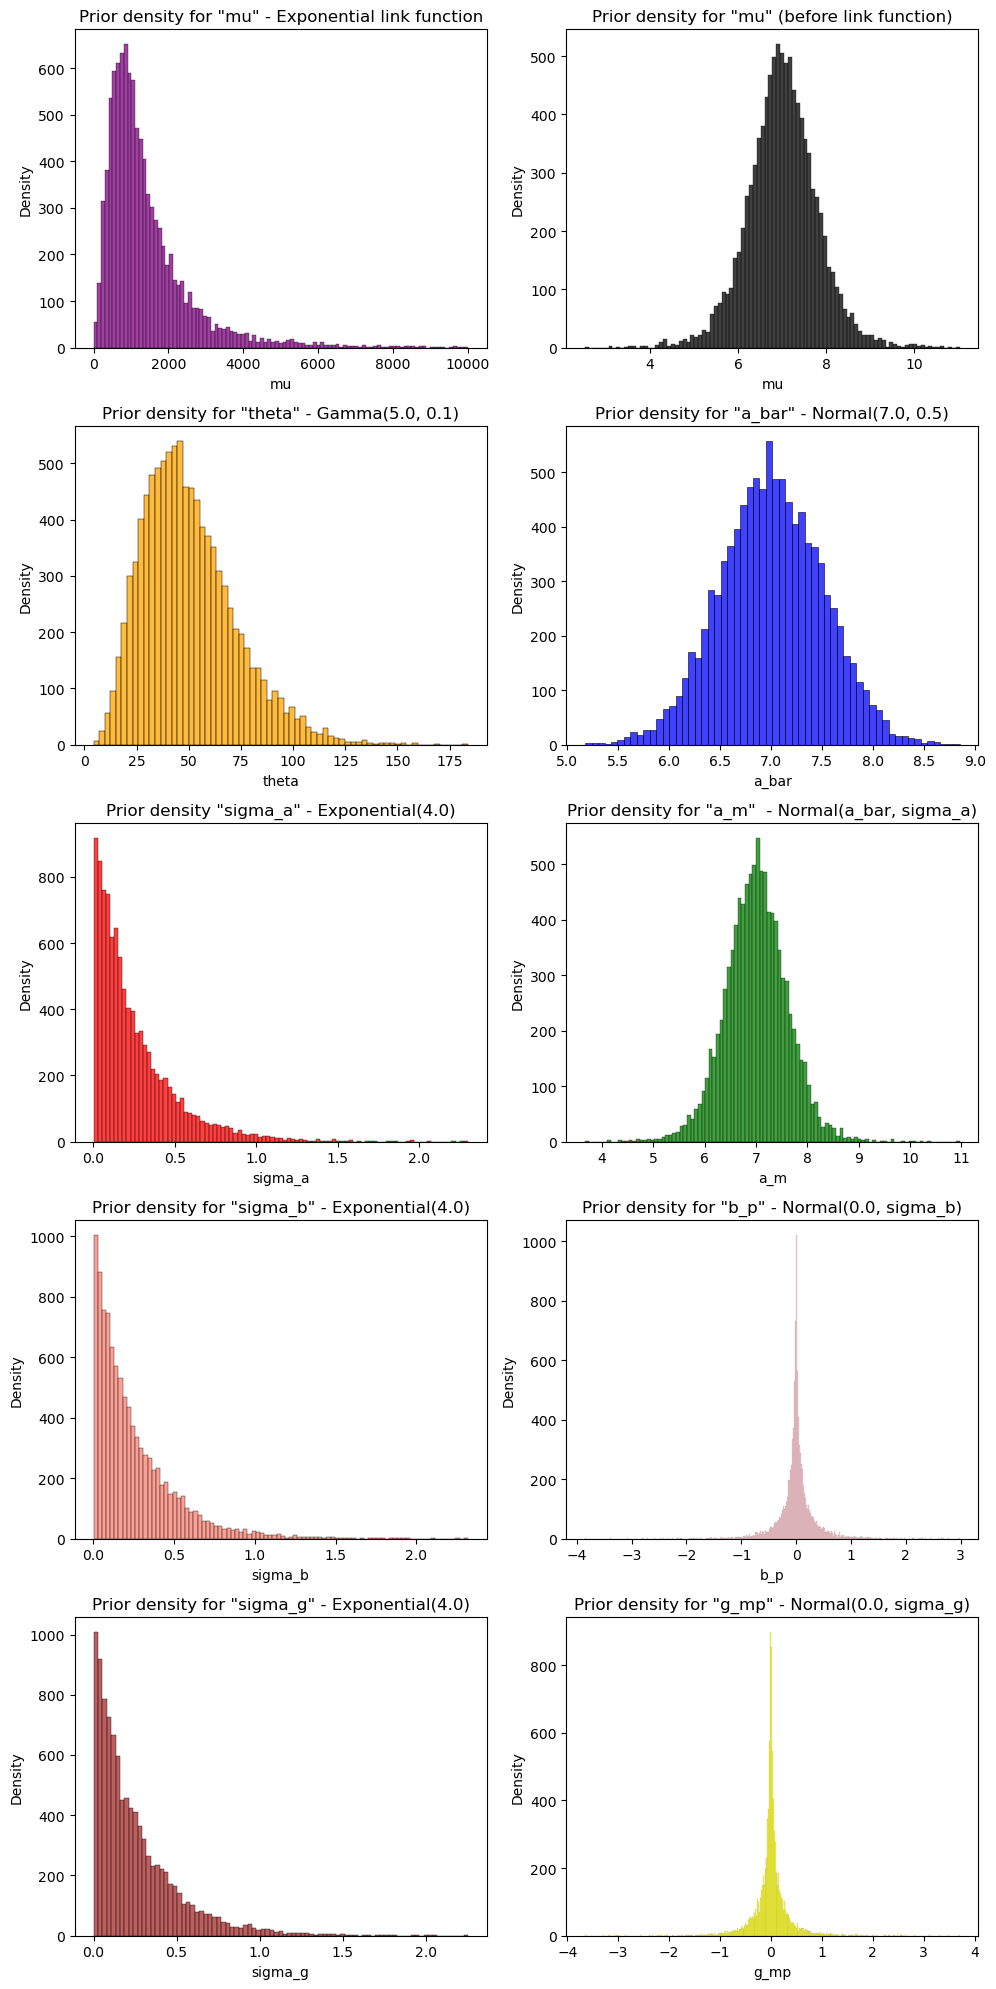

In [18]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (exp), from ln to exp
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p + g_mp))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=5.0, beta=0.1)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    # Use n and p as parameters for the negative binomial
    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    # Plot histogram of observaions 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Algorithm Iterations using Priors ', 'Values',
                                     'darkcyan', bin_range=(0,8000))
    observation_plot.plot()


    # Plot priors for the different parameters
    plots = [
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior density for "mu" - Exponential link function', 'mu', 'purple', bin_range=(0, 10000)),
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior density for "mu" (before link function)', 'mu', 'black'),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior density for "theta" - Gamma(5.0, 0.1)', 'theta', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior density for "a_bar" - Normal(7.0, 0.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior density "sigma_a" - Exponential(4.0)', 'sigma_a', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior density for "a_m"  - Normal(a_bar, sigma_a)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior density for "sigma_b" - Exponential(4.0)', 'sigma_b', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior density for "b_p" - Normal(0.0, sigma_b)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior density for "sigma_g" - Exponential(4.0)', 'sigma_g', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior density for "g_mp" - Normal(0.0, sigma_g)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))

perform_prior_check(4,4,4,7,0.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)


# Model specification

### Data Preperation


In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'AlgorithmIterations')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


### Execute the Model

In [ ]:
with pm.Model() as model:
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    sigma_g = pm.Exponential('sigma_g', 4.0)
    
    # Modules, Parameters and Interactions effects
    # With non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)
    log_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (exp), from ln to exp
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b + log_g))
    
    # Negative Binomial likelihood with parameter n and p
    theta = pm.Gamma('theta', alpha=5.0, beta=0.1) # Dispersion/spread parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=observation_matrix['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Sampling complete!")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_single_parameter.nc")

# Data analysis 

### Generate summary object (without transformations)

In [3]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("overhead_model_single_parameter.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    #'a_m': log_to_exp,
    #'a_bar': log_to_exp,
    #'sigma_a': log_to_exp
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)


### Replace numeric identifiers with descriptive identifiers

In [4]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


mean     sd  hdi_5.5%  \
b_p[TestInsertionProb]                           -0.241  0.011    -0.259   
b_p[Pop]                                         -0.216  0.011    -0.233   
b_p[TestInsertProb]                              -0.075  0.011    -0.092   
b_p[TestChangeProb]                              -0.074  0.011    -0.092   
b_p[StatemInsertProb]                            -0.071  0.011    -0.087   
b_p[Elite]                                       -0.070  0.011    -0.086   
b_p[Crossover]                                   -0.069  0.011    -0.086   
b_p[TestDeleteProb]                              -0.065  0.011    -0.082   
b_p[ChangeParamProb]                             -0.057  0.011    -0.075   
b_p[TourSize]                                    -0.053  0.011    -0.070   
b_p[RandPert]                                    -0.053  0.011    -0.070   
b_p[ChromLen]                                    -0.052  0.011    -0.070   
g_mp[python x TestInsertionProb]                 -0.034  0.021    -0.066   
g_mp[positional_validation x TestInsertionProb]  -0.034  0.021    -0.067   
g_mp[namedtupleutils x Elite]                    -0.033  0.021    -0.068   
g_mp[helpers x Crossover]                        -0.031  0.021    -0.064   
g_mp[namedtupleutils x TourSize]                 -0.031  0.021    -0.064   
g_mp[decorators x Pop]                           -0.030  0.021    -0.065   
g_mp[python x Crossover]                         -0.029  0.021    -0.062   
g_mp[return_from_generator x ChromLen]           -0.027  0.020    -0.058   
g_mp[config x TourSize]                          -0.027  0.020    -0.059   
g_mp[helpers x Pop]                              -0.026  0.020    -0.058   
g_mp[helpers x Elite]                            -0.026  0.021    -0.058   
g_mp[positional_validation x Pop]                -0.025  0.020    -0.057   
g_mp[helpers x TestDeleteProb]                   -0.025  0.020    -0.057   
g_mp[validation x Elite]                         -0.023  0.020    -0.054   
g_mp[maybe x Crossover]                          -0.023  0.020    -0.055   
g_mp[da x TestChangeProb]                        -0.023  0.020    -0.055   
g_mp[packages x Pop]                             -0.022  0.020    -0.055   
g_mp[yield_from x TestChangeProb]                -0.021  0.020    -0.053   
g_mp[da x ChangeParamProb]                       -0.021  0.020    -0.052   
g_mp[packages x TestInsertionProb]               -0.020  0.020    -0.053   
g_mp[helpers x TestInsertProb]                   -0.020  0.020    -0.051   
g_mp[timer x TestChangeProb]                     -0.020  0.020    -0.050   
g_mp[journaling x Pop]                           -0.019  0.020    -0.052   
g_mp[py_base x RandPert]                         -0.019  0.020    -0.051   
g_mp[packages x Crossover]                       -0.019  0.020    -0.052   
g_mp[cmd x Pop]                                  -0.019  0.020    -0.051   
g_mp[validation x StatemInsertProb]              -0.018  0.020    -0.050   
g_mp[da x ChromLen]                              -0.018  0.021    -0.052   
g_mp[helpers x ChangeParamProb]                  -0.018  0.020    -0.051   
g_mp[maybe x TourSize]                           -0.017  0.020    -0.049   
g_mp[validation x ChangeParamProb]               -0.016  0.020    -0.049   
g_mp[maybe x ChromLen]                           -0.016  0.020    -0.048   
g_mp[headers x TestInsertionProb]                -0.016  0.020    -0.047   
g_mp[lazy_import x Pop]                          -0.015  0.020    -0.048   
g_mp[helpers x Elite]                            -0.015  0.020    -0.047   
g_mp[namedtupleutils x TestInsertionProb]        -0.014  0.020    -0.046   
g_mp[signals x TestDeleteProb]                   -0.014  0.020    -0.046   
g_mp[timer x TestInsertionProb]                  -0.013  0.020    -0.044   
g_mp[py_base x TestDeleteProb]                   -0.013  0.020    -0.046   
g_mp[immutable_list x TourSize]                  -0.013  0.020    -0.045   
g_mp[py_base x Elite]  

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

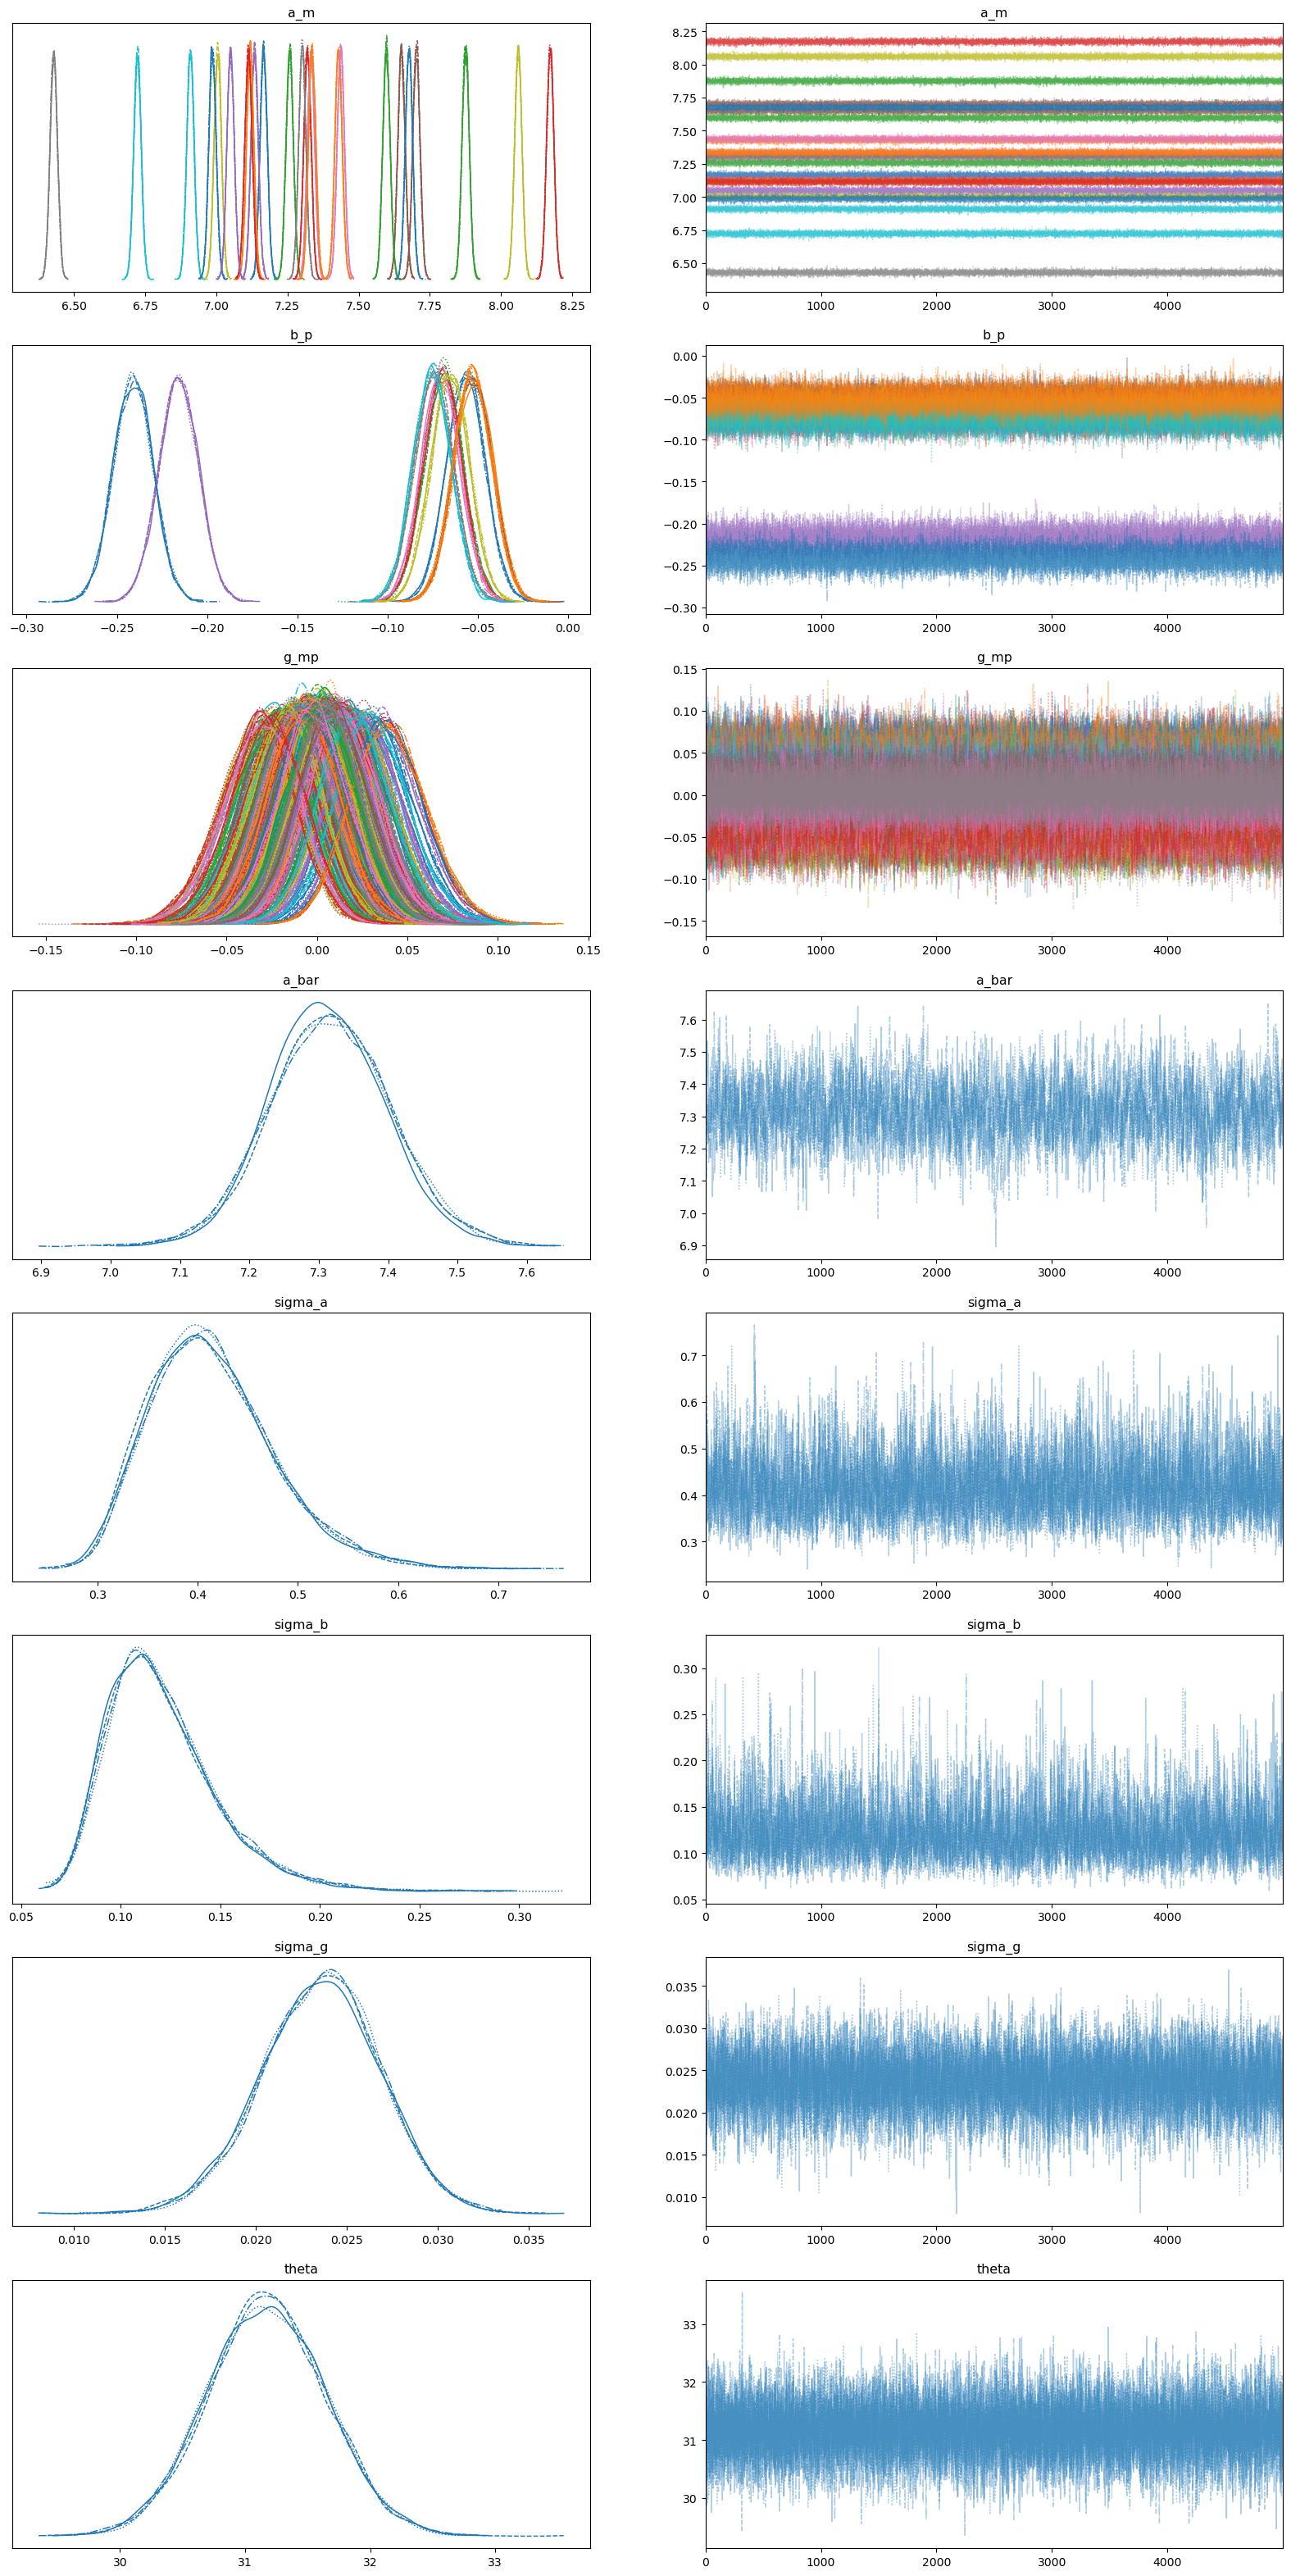

In [5]:
az.plot_trace(idata, var_names=['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta'], figsize=(20, 40))

### Transformed effects

In [13]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("overhead_model_single_parameter.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    'a_m': log_to_exp,
    'b_p': log_to_exp,
    'g_mp': log_to_exp,
    'a_bar': log_to_exp,
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)


In [14]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../single_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


mean       sd  hdi_5.5%  \
sigma_g                                             0.024    0.003     0.019   
sigma_b                                             0.121    0.028     0.079   
sigma_a                                             0.415    0.062     0.315   
b_p[TestInsertionProb]                              0.786    0.009     0.772   
b_p[Pop]                                            0.806    0.009     0.792   
b_p[TestInsertProb]                                 0.927    0.010     0.912   
b_p[TestChangeProb]                                 0.929    0.010     0.912   
b_p[StatemInsertProb]                               0.932    0.010     0.916   
b_p[Crossover]                                      0.933    0.010     0.917   
b_p[Elite]                                          0.933    0.010     0.917   
b_p[TestDeleteProb]                                 0.937    0.010     0.921   
b_p[ChangeParamProb]                                0.945    0.010     0.928   
b_p[TourSize]                                       0.948    0.010     0.932   
b_p[RandPert]                                       0.949    0.010     0.933   
b_p[ChromLen]                                       0.949    0.010     0.933   
g_mp[positional_validation x TestInsertionProb]     0.967    0.020     0.935   
g_mp[python x TestInsertionProb]                    0.967    0.020     0.936   
g_mp[namedtupleutils x Elite]                       0.968    0.020     0.935   
g_mp[helpers x Crossover]                           0.969    0.020     0.938   
g_mp[namedtupleutils x TourSize]                    0.970    0.020     0.938   
g_mp[decorators x Pop]                              0.970    0.020     0.937   
g_mp[python x Crossover]                            0.971    0.020     0.940   
g_mp[config x TourSize]                             0.973    0.020     0.942   
g_mp[return_from_generator x ChromLen]              0.974    0.020     0.944   
g_mp[helpers x TestDeleteProb]                      0.975    0.020     0.944   
g_mp[helpers x Pop]                                 0.975    0.020     0.943   
g_mp[helpers x Elite]                               0.975    0.020     0.943   
g_mp[positional_validation x Pop]                   0.976    0.020     0.945   
g_mp[validation x Elite]                            0.977    0.020     0.945   
g_mp[maybe x Crossover]                             0.977    0.020     0.947   
g_mp[da x TestChangeProb]                           0.978    0.020     0.947   
g_mp[packages x Pop]                                0.979    0.020     0.947   
g_mp[yield_from x TestChangeProb]                   0.980    0.020     0.948   
g_mp[packages x TestInsertionProb]                  0.980    0.020     0.948   
g_mp[da x ChangeParamProb]                          0.980    0.020     0.947   
g_mp[cmd x Pop]                                     0.981    0.020     0.950   
g_mp[packages x Crossover]                          0.981    0.020     0.950   
g_mp[timer x TestChangeProb]                        0.981    0.020     0.951   
g_mp[helpers x TestInsertProb]                      0.981    0.020     0.950   
g_mp[journaling x Pop]                              0.981    0.020     0.949   
g_mp[validation x StatemInsertProb]                 0.982    0.020     0.951   
g_mp[helpers x ChangeParamProb]                     0.982    0.020     0.949   
g_mp[py_base x RandPert]                            0.982    0.020     0.950   
g_mp[da x ChromLen]                                 0.982    0.020     0.949   
g_mp[maybe x TourSize]                              0.983    0.019     0.953   
g_mp[validation x ChangeParamProb]                  0.984    0.020     0.952   
g_mp[headers x TestInsertionProb]                   0.985    0.019     0.954   
g_mp[maybe x ChromLen]                              0.985    0.020     0.954   
g_mp[lazy_import x Pop]                             0.985    0.020     0.954   
g_mp[namedtupleutils x TestInsertionProb]           0

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

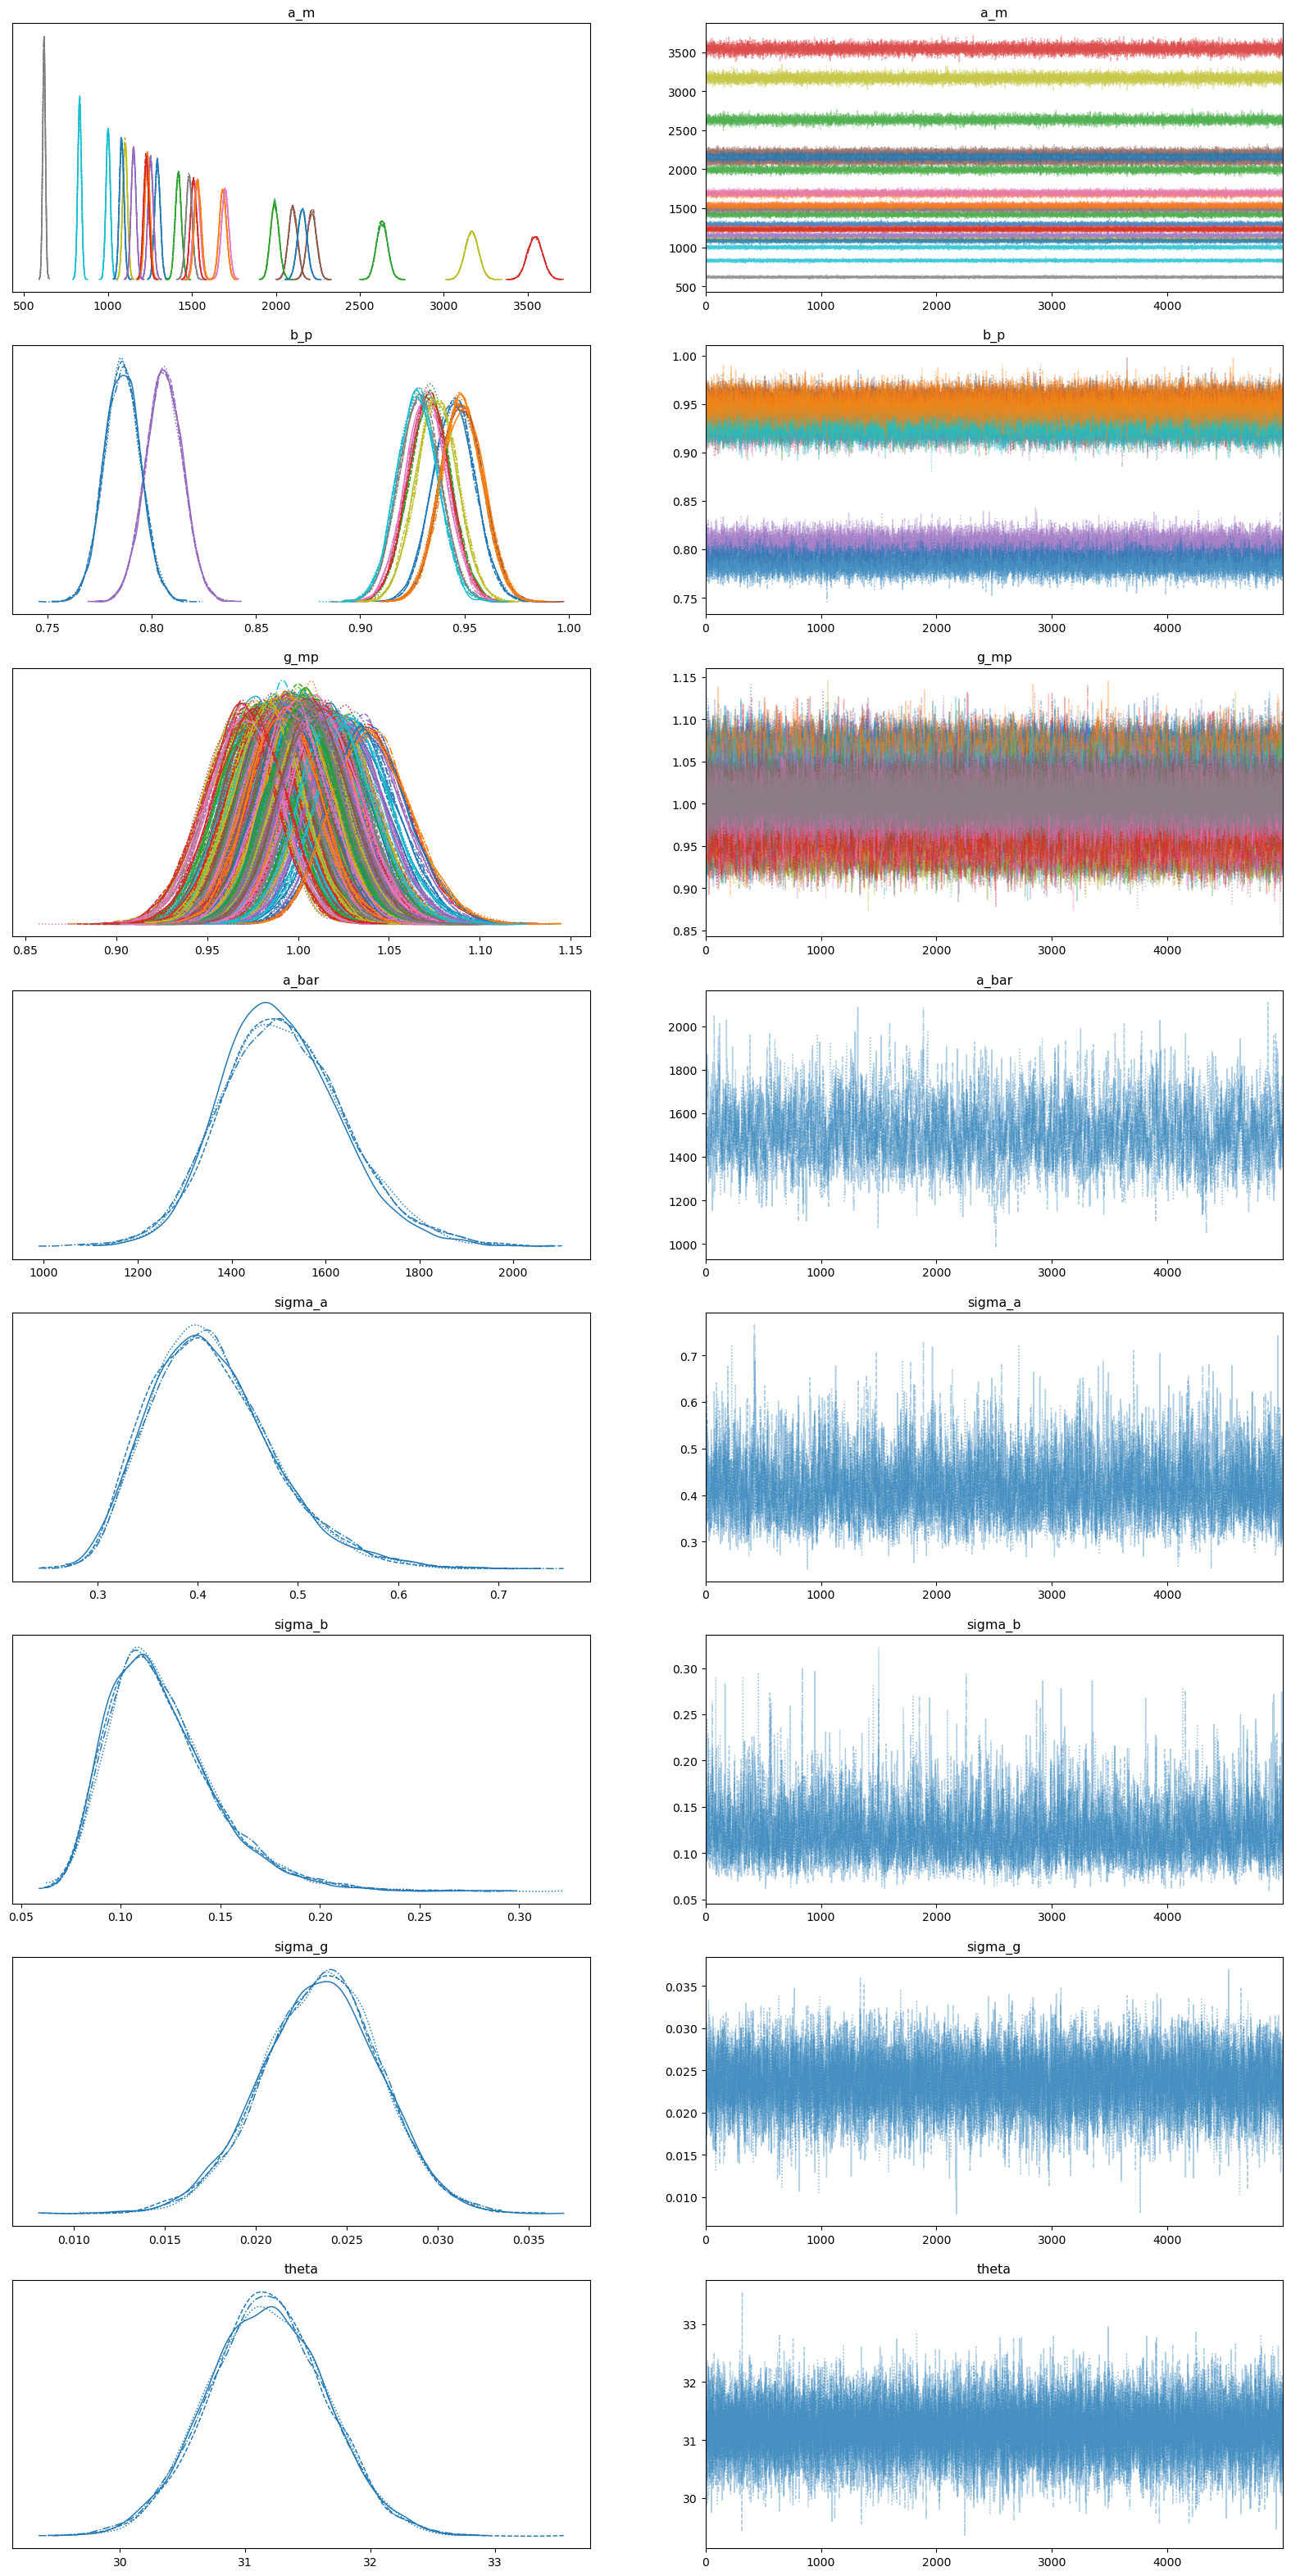

In [15]:
az.plot_trace(idata_transformed, var_names=['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'theta'], figsize=(20, 40))